In [1]:
import pandas as pd
import polars as pl
import polars.selectors as cs
import soccerdata as sd
import matplotlib.pyplot as plt
import sklearn as skl
import pandas as ps
import numpy as np
import pyarrow
import seaborn as sb
from sklearn.decomposition import PCA

[02/15/26 11:41:42] INFO     No custom team name replacements found. You can configure these in       ]8;id=776963;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=789523;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_config.py#91\91]8;;\
                             C:\Users\User\soccerdata\config\teamname_replacements.json.                           

                    INFO     Custom league dict loaded from                                          ]8;id=677517;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=240992;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_config.py#195\195]8;;\
                             C:\Users\User\soccerdata\config\league_dict.json.                                     

In [2]:
fbref = sd.FBref(seasons = "2025")

[02/15/26 11:41:43] INFO     Saving cached data to C:\Users\User\soccerdata\data\FBref               ]8;id=299925;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=857682;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

In [ ]:

"""s = fbref.read_player_season_stats(stat_type="standard")
s1 = pl.from_pandas(s, include_index=True)
progress = fbref.read_player_season_stats(stat_type="possession")
p1 = pl.from_pandas(progress, include_index=True)
passes = fbref.read_player_season_stats(stat_type="passing")
p2 = pl.from_pandas(passes, include_index=True)
creative = fbref.read_player_season_stats(stat_type="goal_shot_creation")
c1 = pl.from_pandas(creative, include_index=True)
defense = fbref.read_player_season_stats(stat_type="defense")
d1 = pl.from_pandas(defense, include_index=True)

S = s1.drop("season")
S = S.drop("('nation', '')")
S = S.drop("('born', '')")
S = S.drop("('age', '')")

S = S.drop([
    "('Playing Time', 'MP')",
    "('Playing Time', 'Starts')",
    "('Playing Time', 'Min')"
])

D = d1.drop("season")
D = D.drop("('nation', '')")
D = D.drop("('born', '')")
D = D.drop("('age', '')")
D = D.drop("('90s', '')")

C = c1.drop("season")
C = C.drop("('nation', '')")
C = C.drop("('born', '')")
C = C.drop("('age', '')")
C = C.drop("('90s', '')")
C = C.drop("('SCA', 'SCA90')")
C = C.drop("('GCA', 'GCA90')")

P = p1.drop("season")
P = P.drop("('nation', '')")
P = P.drop("('born', '')")
P = P.drop("('age', '')")
P = P.drop("('90s', '')")

P2 = p2.drop("season")
P2 = P2.drop("('nation', '')")

P2 = P2.drop("('90s', '')")

all_player = S.join(P, on=["league", "team", "player"], how="inner", suffix="_progress")
all_player = all_player.join(C, on=["league", "team", "player"], how="inner", suffix="_creative")
all_player = all_player.join(D, on=["league", "team", "player"], how="inner", suffix="_defense")
all_player = all_player.join(P2, on=["league", "team", "player"], how="inner", suffix="_passes")
all_player = all_player.drop("('pos', '')_defense")
all_player = all_player.drop("('pos', '')_passes")
all_player = all_player.drop("('pos', '')_creative")
all_player = all_player.drop("('pos', '')_progress")
all_player = all_player.drop(cs.matches(r"^\('Per 90 Minutes'.*"))
all_player = all_player.fill_nan(0.0)
all_player.write_csv("player_stats.csv")
"""

In [34]:
all_player = pl.read_csv("player_stats.csv")
all_player

league,team,player,"('pos', '')","('Playing Time', '90s')","('Performance', 'Gls')","('Performance', 'Ast')","('Performance', 'G+A')","('Performance', 'G-PK')","('Performance', 'PK')","('Performance', 'PKatt')","('Performance', 'CrdY')","('Performance', 'CrdR')","('Expected', 'xG')","('Expected', 'npxG')","('Expected', 'xAG')","('Expected', 'npxG+xAG')","('Progression', 'PrgC')","('Progression', 'PrgP')","('Progression', 'PrgR')","('Touches', 'Touches')","('Touches', 'Def Pen')","('Touches', 'Def 3rd')","('Touches', 'Mid 3rd')","('Touches', 'Att 3rd')","('Touches', 'Att Pen')","('Touches', 'Live')","('Take-Ons', 'Att')","('Take-Ons', 'Succ')","('Take-Ons', 'Succ%')","('Take-Ons', 'Tkld')","('Take-Ons', 'Tkld%')","('Carries', 'Carries')","('Carries', 'TotDist')","('Carries', 'PrgDist')","('Carries', 'PrgC')","('Carries', '1/3')",…,"('Tackles', 'Att 3rd')","('Challenges', 'Tkl')","('Challenges', 'Att')","('Challenges', 'Tkl%')","('Challenges', 'Lost')","('Blocks', 'Blocks')","('Blocks', 'Sh')","('Blocks', 'Pass')","('Int', '')","('Tkl+Int', '')","('Clr', '')","('Err', '')","('age', '')","('born', '')","('Total', 'Cmp')","('Total', 'Att')","('Total', 'Cmp%')","('Total', 'TotDist')","('Total', 'PrgDist')","('Short', 'Cmp')","('Short', 'Att')","('Short', 'Cmp%')","('Medium', 'Cmp')","('Medium', 'Att')","('Medium', 'Cmp%')","('Long', 'Cmp')","('Long', 'Att')","('Long', 'Cmp%')","('Ast', '')","('xAG', '')","('Expected', 'xA')","('Expected', 'A-xAG')","('KP', '')","('1/3', '')","('PPA', '')","('CrsPA', '')","('PrgP', '')"
str,str,str,str,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,f64,i64,i64,i64,i64,i64,…,i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,f64,i64,i64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,f64,f64,f64,i64,i64,i64,i64,i64
"""ENG-EFL Championship""","""Birmingham City""","""Alex Cochrane""","""DF""",16.3,1,4,5,1,0,0,3,0,0.3,0.3,1.8,2.2,16,100,32,1222,42,368,607,255,3,1222,6,3,50.0,3,50.0,578,2341,1187,16,12,…,4,14,26,53.8,12,7,2,5,19,37,56,0,"""25-242""",2000,776,1075,72.2,13702,5836,344,371,92.7,369,467,79.0,56,202,27.7,4,1.8,1.7,2.2,18,87,9,7,100
"""ENG-EFL Championship""","""Birmingham City""","""Alfons Sampsted""","""DF,MF""",0.3,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1,1,1,12,0,2,5,5,1,12,0,0,null,0,null,6,23,17,1,0,…,0,0,0,null,0,0,0,0,0,0,2,0,"""27-257""",1998,6,9,66.7,104,38,2,4,50.0,4,4,100.0,0,1,0.0,0,0.0,0.0,0.0,0,1,0,0,1
"""ENG-EFL Championship""","""Birmingham City""","""Bright Osayi-Samuel""","""DF""",8.7,0,0,0,0,0,0,5,0,0.3,0.3,0.2,0.5,17,17,43,459,17,132,214,118,12,459,16,8,50.0,8,50.0,205,1189,550,17,16,…,0,3,9,33.3,6,4,0,4,11,20,20,0,"""27-353""",1997,295,374,78.9,4555,1173,153,171,89.5,128,158,81.0,9,25,36.0,0,0.2,0.3,-0.2,3,15,4,2,17
"""ENG-EFL Championship""","""Birmingham City""","""Christoph Klarer""","""DF""",21.0,2,0,2,2,0,0,4,0,1.2,1.2,0.7,1.9,20,89,4,1781,217,868,845,79,30,1781,12,7,58.3,4,33.3,1016,5650,3606,20,13,…,1,15,23,65.2,8,11,7,4,29,52,157,0,"""25-188""",2000,1329,1519,87.5,24763,8927,446,477,93.5,785,852,92.1,90,166,54.2,0,0.7,0.7,-0.7,6,76,5,1,89
"""ENG-EFL Championship""","""Birmingham City""","""Demarai Gray""","""FW,MF""",17.5,5,4,9,5,0,0,2,0,3.5,3.5,4.1,7.6,55,33,159,779,18,88,293,411,59,779,53,21,39.6,27,50.9,472,3251,1574,55,38,…,8,16,27,59.3,11,23,1,22,6,30,19,0,"""29-174""",1996,393,550,71.5,6276,1227,215,248,86.7,137,189,72.5,31,76,40.8,4,4.1,3.9,-0.1,21,18,15,5,33
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Por-Primeira Liga""","""Vitória""","""Tomás Händel""","""MF""",3.0,0,1,1,0,0,0,0,0,0.2,0.2,0.3,0.5,4,11,9,136,9,24,78,35,2,136,0,0,null,0,null,72,276,146,4,2,…,0,3,5,60.0,2,2,1,1,5,11,3,1,"""25-023""",2000,89,114,78.1,1403,292,49,59,83.1,31,38,81.6,6,10,60.0,1,0.3,0.3,0.7,2,10,1,0,11
"""Por-Primeira Liga""","""Vitória""","""Toni Borevkovic""","""DF""",1.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,1,0,

In [35]:
all_player = all_player.filter((pl.col("('pos', '')").str.contains("DF")))
all_player = all_player.filter((pl.col("('born', '')") >= 1997))
#all_player = all_player.filter((pl.col("('Playing Time', '90s')") >= 5))
#all_player = all_player.filter(pl.col("league").str.contains("ENG-Premier League"))
all_player = all_player.drop("('pos', '')")
all_player = all_player.drop("('born', '')")
all_player.drop("('age', '')")

league,team,player,"('Playing Time', '90s')","('Performance', 'Gls')","('Performance', 'Ast')","('Performance', 'G+A')","('Performance', 'G-PK')","('Performance', 'PK')","('Performance', 'PKatt')","('Performance', 'CrdY')","('Performance', 'CrdR')","('Expected', 'xG')","('Expected', 'npxG')","('Expected', 'xAG')","('Expected', 'npxG+xAG')","('Progression', 'PrgC')","('Progression', 'PrgP')","('Progression', 'PrgR')","('Touches', 'Touches')","('Touches', 'Def Pen')","('Touches', 'Def 3rd')","('Touches', 'Mid 3rd')","('Touches', 'Att 3rd')","('Touches', 'Att Pen')","('Touches', 'Live')","('Take-Ons', 'Att')","('Take-Ons', 'Succ')","('Take-Ons', 'Succ%')","('Take-Ons', 'Tkld')","('Take-Ons', 'Tkld%')","('Carries', 'Carries')","('Carries', 'TotDist')","('Carries', 'PrgDist')","('Carries', 'PrgC')","('Carries', '1/3')","('Carries', 'CPA')",…,"('Tackles', 'Def 3rd')","('Tackles', 'Mid 3rd')","('Tackles', 'Att 3rd')","('Challenges', 'Tkl')","('Challenges', 'Att')","('Challenges', 'Tkl%')","('Challenges', 'Lost')","('Blocks', 'Blocks')","('Blocks', 'Sh')","('Blocks', 'Pass')","('Int', '')","('Tkl+Int', '')","('Clr', '')","('Err', '')","('Total', 'Cmp')","('Total', 'Att')","('Total', 'Cmp%')","('Total', 'TotDist')","('Total', 'PrgDist')","('Short', 'Cmp')","('Short', 'Att')","('Short', 'Cmp%')","('Medium', 'Cmp')","('Medium', 'Att')","('Medium', 'Cmp%')","('Long', 'Cmp')","('Long', 'Att')","('Long', 'Cmp%')","('Ast', '')","('xAG', '')","('Expected', 'xA')","('Expected', 'A-xAG')","('KP', '')","('1/3', '')","('PPA', '')","('CrsPA', '')","('PrgP', '')"
str,str,str,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,f64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,f64,f64,f64,i64,i64,i64,i64,i64
"""ENG-EFL Championship""","""Birmingham City""","""Alex Cochrane""",16.3,1,4,5,1,0,0,3,0,0.3,0.3,1.8,2.2,16,100,32,1222,42,368,607,255,3,1222,6,3,50.0,3,50.0,578,2341,1187,16,12,1,…,9,5,4,14,26,53.8,12,7,2,5,19,37,56,0,776,1075,72.2,13702,5836,344,371,92.7,369,467,79.0,56,202,27.7,4,1.8,1.7,2.2,18,87,9,7,100
"""ENG-EFL Championship""","""Birmingham City""","""Alfons Sampsted""",0.3,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1,1,1,12,0,2,5,5,1,12,0,0,null,0,null,6,23,17,1,0,0,…,0,0,0,0,0,null,0,0,0,0,0,0,2,0,6,9,66.7,104,38,2,4,50.0,4,4,100.0,0,1,0.0,0,0.0,0.0,0.0,0,1,0,0,1
"""ENG-EFL Championship""","""Birmingham City""","""Bright Osayi-Samuel""",8.7,0,0,0,0,0,0,5,0,0.3,0.3,0.2,0.5,17,17,43,459,17,132,214,118,12,459,16,8,50.0,8,50.0,205,1189,550,17,16,3,…,4,5,0,3,9,33.3,6,4,0,4,11,20,20,0,295,374,78.9,4555,1173,153,171,89.5,128,158,81.0,9,25,36.0,0,0.2,0.3,-0.2,3,15,4,2,17
"""ENG-EFL Championship""","""Birmingham City""","""Christoph Klarer""",21.0,2,0,2,2,0,0,4,0,1.2,1.2,0.7,1.9,20,89,4,1781,217,868,845,79,30,1781,12,7,58.3,4,33.3,1016,5650,3606,20,13,0,…,17,5,1,15,23,65.2,8,11,7,4,29,52,157,0,1329,1519,87.5,24763,8927,446,477,93.5,785,852,92.1,90,166,54.2,0,0.7,0.7,-0.7,6,76,5,1,89
"""ENG-EFL Championship""","""Birmingham City""","""Eiran Cashin""",2.1,0,0,0,0,0,0,0,0,0.3,0.3,0.0,0.3,2,10,0,169,34,92,67,11,3,169,1,0,0.0,1,100.0,78,464,319,2,2,0,…,5,0,0,4,6,66.7,2,1,1,0,2,7,26,1,114,126,90.5,2294,1037,30,30,100.0,71,76,93.4,13,20,65.0,0,0.0,0.1,0.0,0,12,1,0,10
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Por-Primeira Liga""","""Vitória""","""Paulo Vitor""",0.1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,7,3,4,3,0,0,7,0,0,null,0,null,0,0,0,0,0,0,…,0,0,0,0,0,null,0,0,0,0,0,0,2,0,4,5,80.0,114,69,1,2,50.0,2,2,100.0,1,1,100.0,0,0.0,0.0,0.0,0,0,0,0,0
"""Por-Primeira Liga""","""Vitória""","""Toni Borevkovic""",1.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,1,0,60,7,41,18,1,1,60,0,0,null,0,null,43,169,98,0,0,0,…,0,0,0,0,0,null,0,1,1,0,0,0,4,2,43,52,82.7,854,298,12,14,85.7,24,24,100.0,6,12,50.0,0,0.0,0.0,0.0,1,2,0,0,1
"""Po

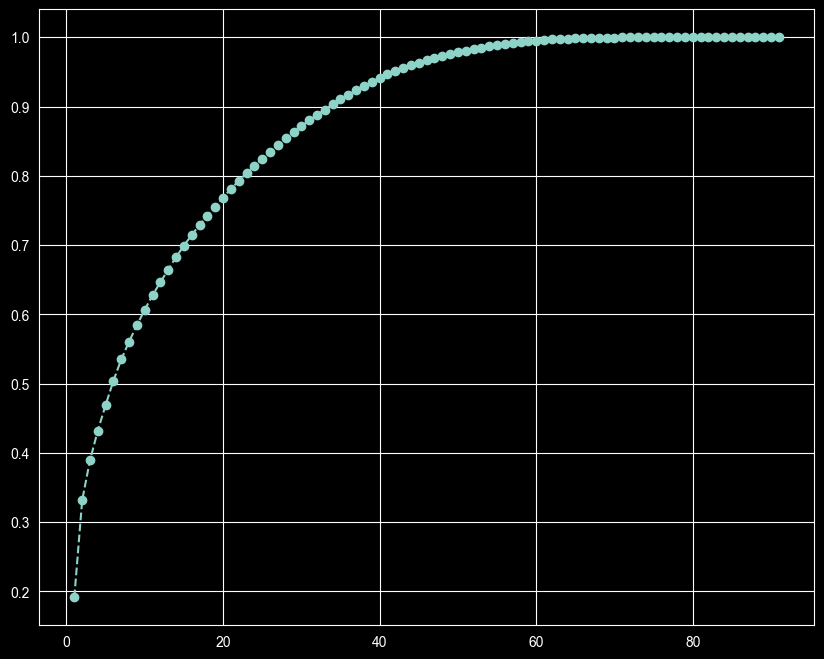

In [36]:
exclude_cols = ["born", "season", "league", "team", "player"]

numeric_cols_all = all_player.select(cs.numeric().exclude(exclude_cols)).columns

cols_to_normalize = [
    c for c in numeric_cols_all
    if "90s" not in c
    and "%" not in c
    and "Pct" not in c
]

all_player = all_player.with_columns([
    (pl.col(col_name) / pl.col("('Playing Time', '90s')")).alias(col_name)
    for col_name in cols_to_normalize
])

all_player = all_player.fill_nan(0.0).fill_null(0.0).with_columns([
    pl.when(pl.col(col_name).is_infinite())
      .then(0.0)
      .otherwise(pl.col(col_name))
      .alias(col_name)
    for col_name in numeric_cols_all
])
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

identifier_cols = ["league", "team", "player"]
numeric_data = all_player.select(pl.col(pl.Float64, pl.Int64))

X_filtered = numeric_data.fill_null(0).to_numpy()

scaler = StandardScaler()
#fit the number into -1 ~ 1
X_scaled = scaler.fit_transform(X_filtered)

tester = pd.DataFrame(X_scaled)
tester
pca = PCA()
pca.fit(tester)
pca.explained_variance_ratio_
plt.figure(figsize=(10, 8))
plt.plot(range(1, 92), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')

In [37]:
#結果：23変数くらいが丸い。それ前後は弄ってみても良いかも。
pca = PCA(23)
pca.fit(tester)
pcaed = pca.transform(tester)

In [40]:
idx = all_player.with_row_index().filter(pl.col("player") == "Luca Pellegrini").select("index").item()
scaled = pcaed[idx].reshape(1, -1)

In [41]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=20, metric='cosine')
nn.fit(pcaed)

distances, indices = nn.kneighbors([pcaed[idx]])

similar_players_indices = indices[0][1:]

all_player[similar_players_indices].select("player", "team", "league")

player,team,league
str,str,str
"""Alex Cochrane""","""Birmingham City""","""ENG-EFL Championship"""
"""Reece James""","""Chelsea""","""ENG-Premier League"""
"""Aske Adelgaard""","""Go Ahead Eag""","""NED-Eredivisie"""
"""Aarón Martín""","""Genoa""","""ITA-Serie A"""
"""Juan Miranda""","""Bologna""","""ITA-Serie A"""
…,…,…
"""Caio Henrique Oliveira Silva""","""Monaco""","""FRA-Ligue 1"""
"""Pedro Porro""","""Tottenham""","""ENG-Premier League"""
"""Alfie Gilchrist""","""West Brom""","""ENG-EFL Championship"""
